# 1. Feature Engineering and Data Cleaning

Feature Engineering은 데이터셋에 있는 특성들을 분석하고 변형하여 예측 모델링에 적합한 형태로 만드는 과정입니다. <br/>
<br/>

주어진 데이터셋에는 모든 특성이 중요하다고 할 수는 없습니다. 중복된 특성들이 많이 존재할 수 있으며, 이러한 중복된 특성들은 제거해야 합니다. 또한, 다른 특성들로부터 정보를 관찰하거나 추출하여 새로운 특성을 얻거나 추가할 수도 있습니다. <br/>
<br/>

이름 특성을 사용하여 이니셜(initials) 특성을 추출하는 것이 한 예입니다. 이제 우리는 새로운 특성을 얻을 수 있고 몇 가지 특성을 제거할 수 있도록 해보겠습니다. 또한, 예측 모델링에 적합한 형태로 기존의 관련된 특성들을 변형할 것입니다.

**Age_band** <br/>

나이 특성의 문제점: <br/>
앞서 말했듯이 나이는 연속적인 특성입니다. 그러나 기계 학습 모델에서 연속 변수를 다룰 때 문제가 발생합니다. <br/>

예를 들어, 선수들을 성별로 그룹화하거나 정렬하라고 하면 쉽게 남성과 여성으로 분리할 수 있습니다. <br/>

그러나 나이로 그룹화하면 30명의 사람이 있다면 30개의 나이 값이 있을 수 있습니다. 이것은 문제가 됩니다. <br/>

이러한 연속적인 값들을 범주형 값으로 변환해야 합니다. 이를 위해 구간화(Binning) 또는 정규화(Normalization)를 사용할 수 있습니다. 여기서는 구간화를 사용하여 여러 개의 나이 범위를 하나의 구간으로 묶거나 하나의 값으로 할당할 것입니다. <br/>

예를 들어, 탑승자 중 최고 연령은 80세였습니다. 따라서 0부터 80까지의 범위를 5개의 구간으로 나누겠습니다. 따라서 구간 크기는 80/5 = 16이 됩니다.

먼저 이전에 진행한 내용을 불러오겠습니다.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
data = pd.read_csv(r'C:\Users\82104\OneDrive\바탕 화면\kaggle\Transcription\titanic\data\train.csv')

In [5]:
data['Initial'] = 0
for i in data:
    data['Initial'] = data.Name.str.extract('([A-Za-z]+)\.') # lets extract the salutations

In [6]:
data['Initial'].replace(['Mlle', 'Mme', 'Ms', 'Dr', 'Major', 'Lady', 'Countess', 'Jonkheer', 'Col', 'Rev', 'Capt', 'Sir', 'Don'],
                        ['Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Other', 'Other', 'Other', 'Mr', 'Mr', 'Mr'], inplace = True)

In [7]:
## Assigning the NaN Values with the Ceil values of the mean ages
data.loc[(data.Age.isnull())&(data.Initial == 'Mr'), 'Age'] = 33
data.loc[(data.Age.isnull())&(data.Initial == 'Mrs'), 'Age'] = 36
data.loc[(data.Age.isnull())&(data.Initial == 'Master'), 'Age'] = 5
data.loc[(data.Age.isnull())&(data.Initial == 'Miss'), 'Age'] = 22
data.loc[(data.Age.isnull())&(data.Initial == 'Other'), 'Age'] = 46

In [8]:
data['Embarked'].fillna('S', inplace = True)

나이 구간대를 만들겠습니다.

In [9]:
data['Age_band'] = 0
data.loc[data['Age'] <= 16, 'Age_band'] = 0
data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age_band'] = 1
data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age_band'] = 2
data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age_band'] = 3
data.loc[data['Age'] > 64, 'Age_band'] = 4
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2


In [10]:
data['Age_band'].value_counts().to_frame().style.background_gradient(cmap = 'summer') # checking the number of passengers in each band

,Age_band
1,382
2,325
0,104
3,69
4,11


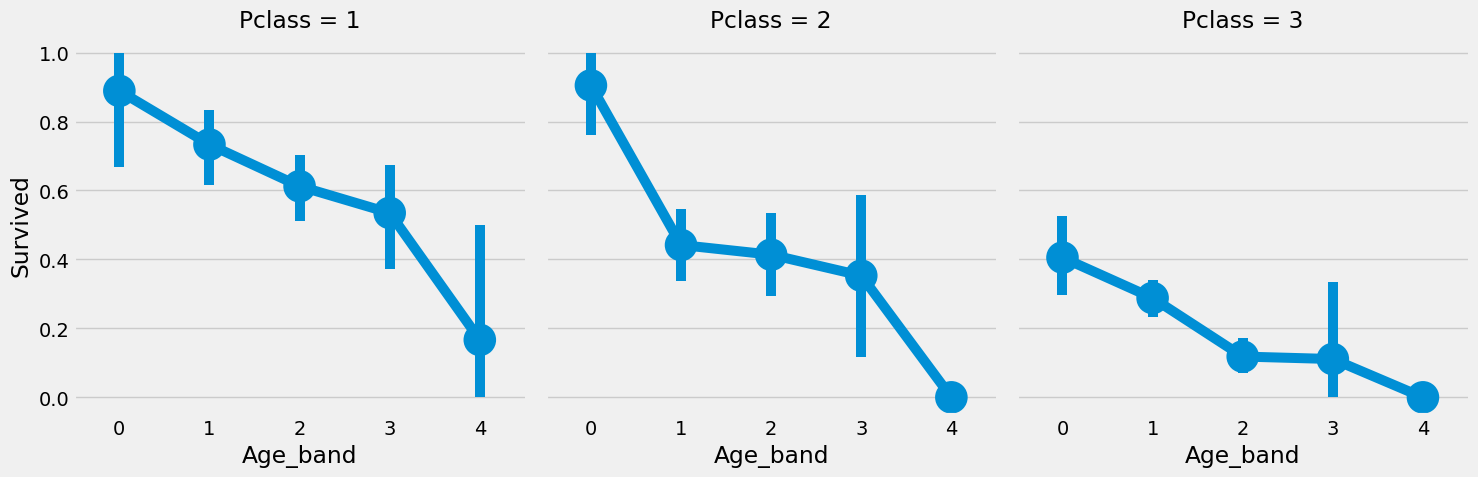

In [17]:
sns.catplot(x = 'Age_band', y = 'Survived', data = data, col = 'Pclass', kind = 'point')
plt.show()

나이가 증가함에 따라 생존율이 Pclass와 관계없이 감소하는 것으로 보여집니다.

**Family_size and Alone** <br/>

이 시점에서 "Family_size"와 "Alone"이라는 새로운 특성을 생성하고 분석할 수 있습니다. 이 특성은 Parch와 SibSp의 합으로 이루어집니다. 이를 통해 승객의 가족 구성원 수와 생존율 사이에 관련성이 있는지 확인할 수 있습니다. "Alone"은 승객이 혼자인지 여부를 나타냅니다.

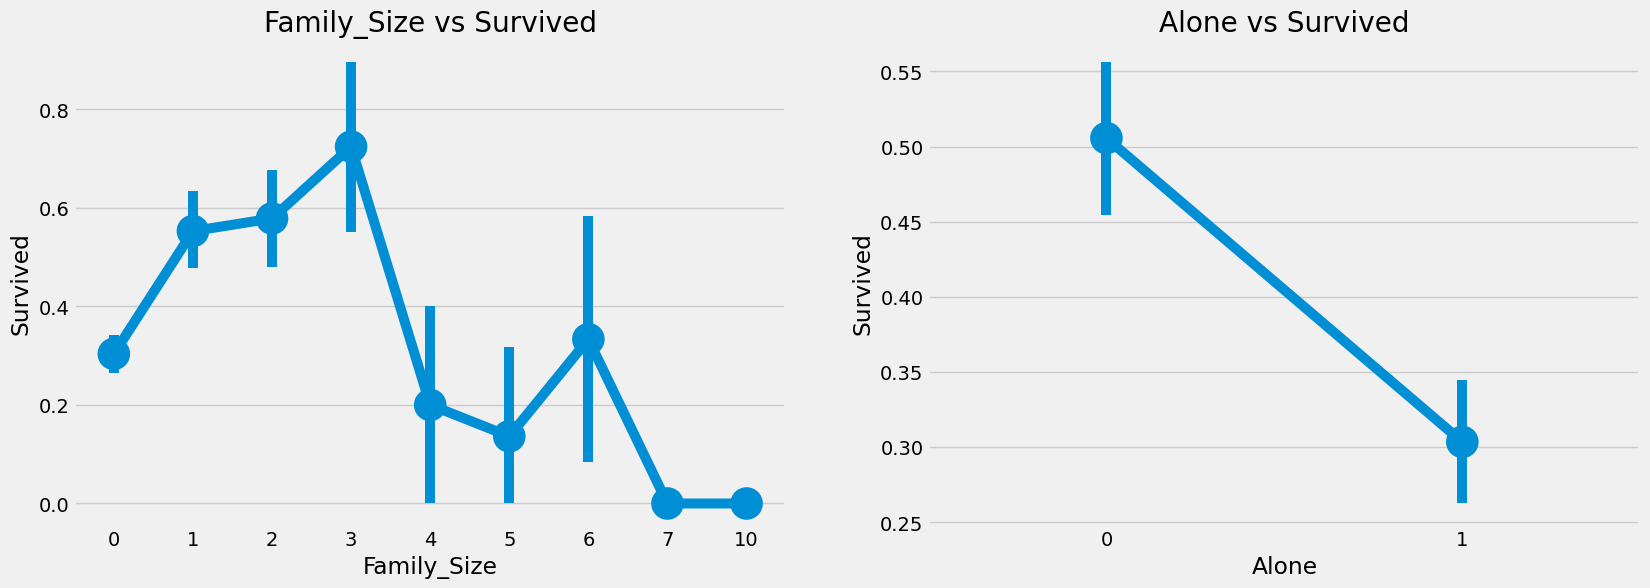

In [19]:
data['Family_Size'] = 0
data['Family_Size'] = data['Parch'] + data['SibSp'] # family size

data['Alone'] = 0
data.loc[data.Family_Size == 0, 'Alone'] = 1 # Alone

f, ax = plt.subplots(1, 2, figsize = (18, 6))
sns.pointplot(x = 'Family_Size', y = 'Survived', data = data, ax = ax[0])
ax[0].set_title('Family_Size vs Survived')
sns.pointplot(x = 'Alone', y = 'Survived', data = data, ax = ax[1])
ax[1].set_title('Alone vs Survived')
plt.close(2)
plt.close(3)
plt.show()

"Family_Size"가 0인 경우는 승객이 혼자인 경우를 의미합니다. 분명히, 혼자인 경우 또는 가족 구성원이 없는 경우 생존 확률이 매우 낮습니다. 가족 구성원 수가 4보다 큰 경우에도 생존 확률이 감소하는 것으로 나타납니다. 이는 모델에 대해 중요한 특성으로 보입니다. 더 자세히 살펴보겠습니다.

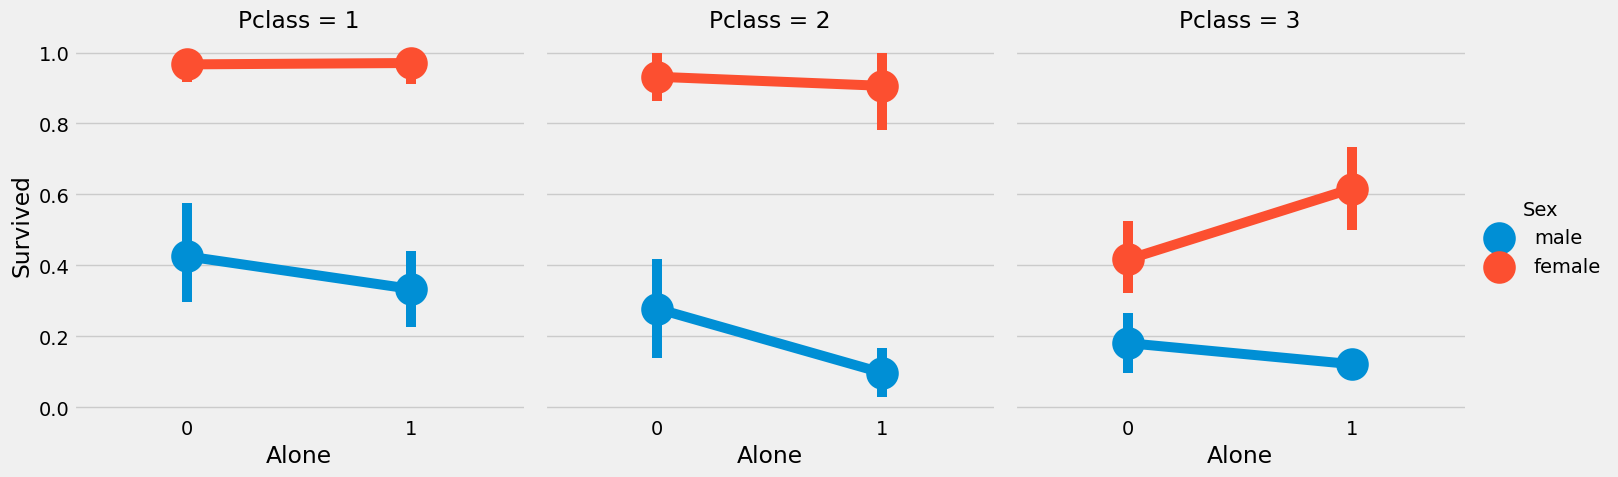

In [21]:
sns.catplot(x = 'Alone', y = 'Survived', data = data, hue = 'Sex', col = 'Pclass', kind = 'point')
plt.show()

성별이나 객실 등급과는 관계없이 혼자인 경우는 해로운 것으로 보입니다. 다만 Pclass 3 의 경우, 가족이 없는 여성의 생존 확률이 가족이 있는 여성의 생존 확률보다 높은 경향이 있습니다.

**Fare_Range** <br/>
운임(fare)도 연속형 변수이므로 이를 순서 값(ordinal value)으로 변환해야 합니다. 이를 위해 pandas의 'qcut' 합수를 사용할 것입니다. <br/>
<br/>

'qcut'함수는 우리가 지정한 구간 수에 따라 값을 나누거나 정렬합니다. 예를 들어, 5개의 구간을 지정하면 값들이 균등하게 5개의 별도의 구간 또는 값 범위로 정렬됩니다.

In [22]:
data['Fare_Range'] = pd.qcut(data['Fare'], 4)
data.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap = 'summer_r')

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


위에서 언급한 바와 같이, 운임 범위가 증가할수록 생존 확률이 증가하는 것을 명확히 알 수 있습니다. <br/>
<br/>

이제는 우리는 Fare_Range 값을 그대로 전달할 수 없습니다. 우리는 이를 Age_Band와 동일한 단독 값으로 변환해야 합니다.

In [23]:
data['Fare_cat'] = 0
data.loc[data['Fare'] <= 7.91, 'Fare_cat'] = 0
data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare_cat'] = 1
data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare_cat'] = 2
data.loc[(data['Fare'] > 31) & (data['Fare'] <= 513), 'Fare_cat'] = 3

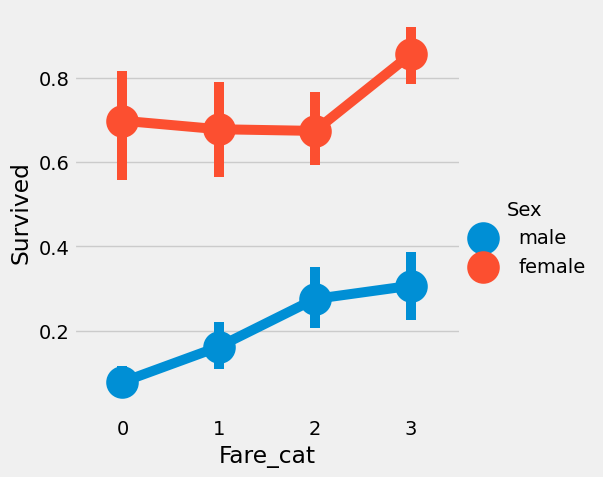

In [24]:
sns.catplot(x = 'Fare_cat', y = 'Survived', data = data, hue = 'Sex', kind = 'point')
plt.show()

확실히, Fare_cat이 증가함에 따라 생존 가능성도 증가합니다. 이 특성은 성별과 함께 모델링 중에 중요한 특성이 될 수 있습니다.

**Converting String Values into Numeric** <br/>

머신 러닝 모델에는 문자열을 전달할 수 없으므로, Sex, Embarked 등과 같은 특성을 숫자 값으로 변환해야 합니다.

In [25]:
data['Sex'].replace(['male', 'female'], [0, 1], inplace = True)
data['Embarked'].replace(['S', 'C', 'Q'], [0, 1, 2], inplace = True)
data['Initial'].replace(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], [0, 1, 2, 3, 4], inplace = True)

불필요한 특성 제거하기 <br/>
Name(이름) --> 카테고리 값으로 변환할 수 없으므로 필요하지 않습니다. <br/>
Age(나이) --> Age_band 특성이 있으므로 불필요합니다. <br/>
Ticket(티켓) --> 범주화할 수 없는 임의의 문자열입니다. <br/>
Fare(운임) --> Fare_cat 특성이 있으므로 불필요합니다. <br/>
Cabin(객실) --> 많은 NaN 값이 있으며, 많은 승객이 여러 객실을 가지고 있습니다. 따라서 이는 쓸모 없는 특성입니다. <br/>
Fare_Range(운임 범위) --> fare_cat 특성이 있습니다. <br/>
PassengerId(승객 ID) --> 범주화할 수 없습니다.

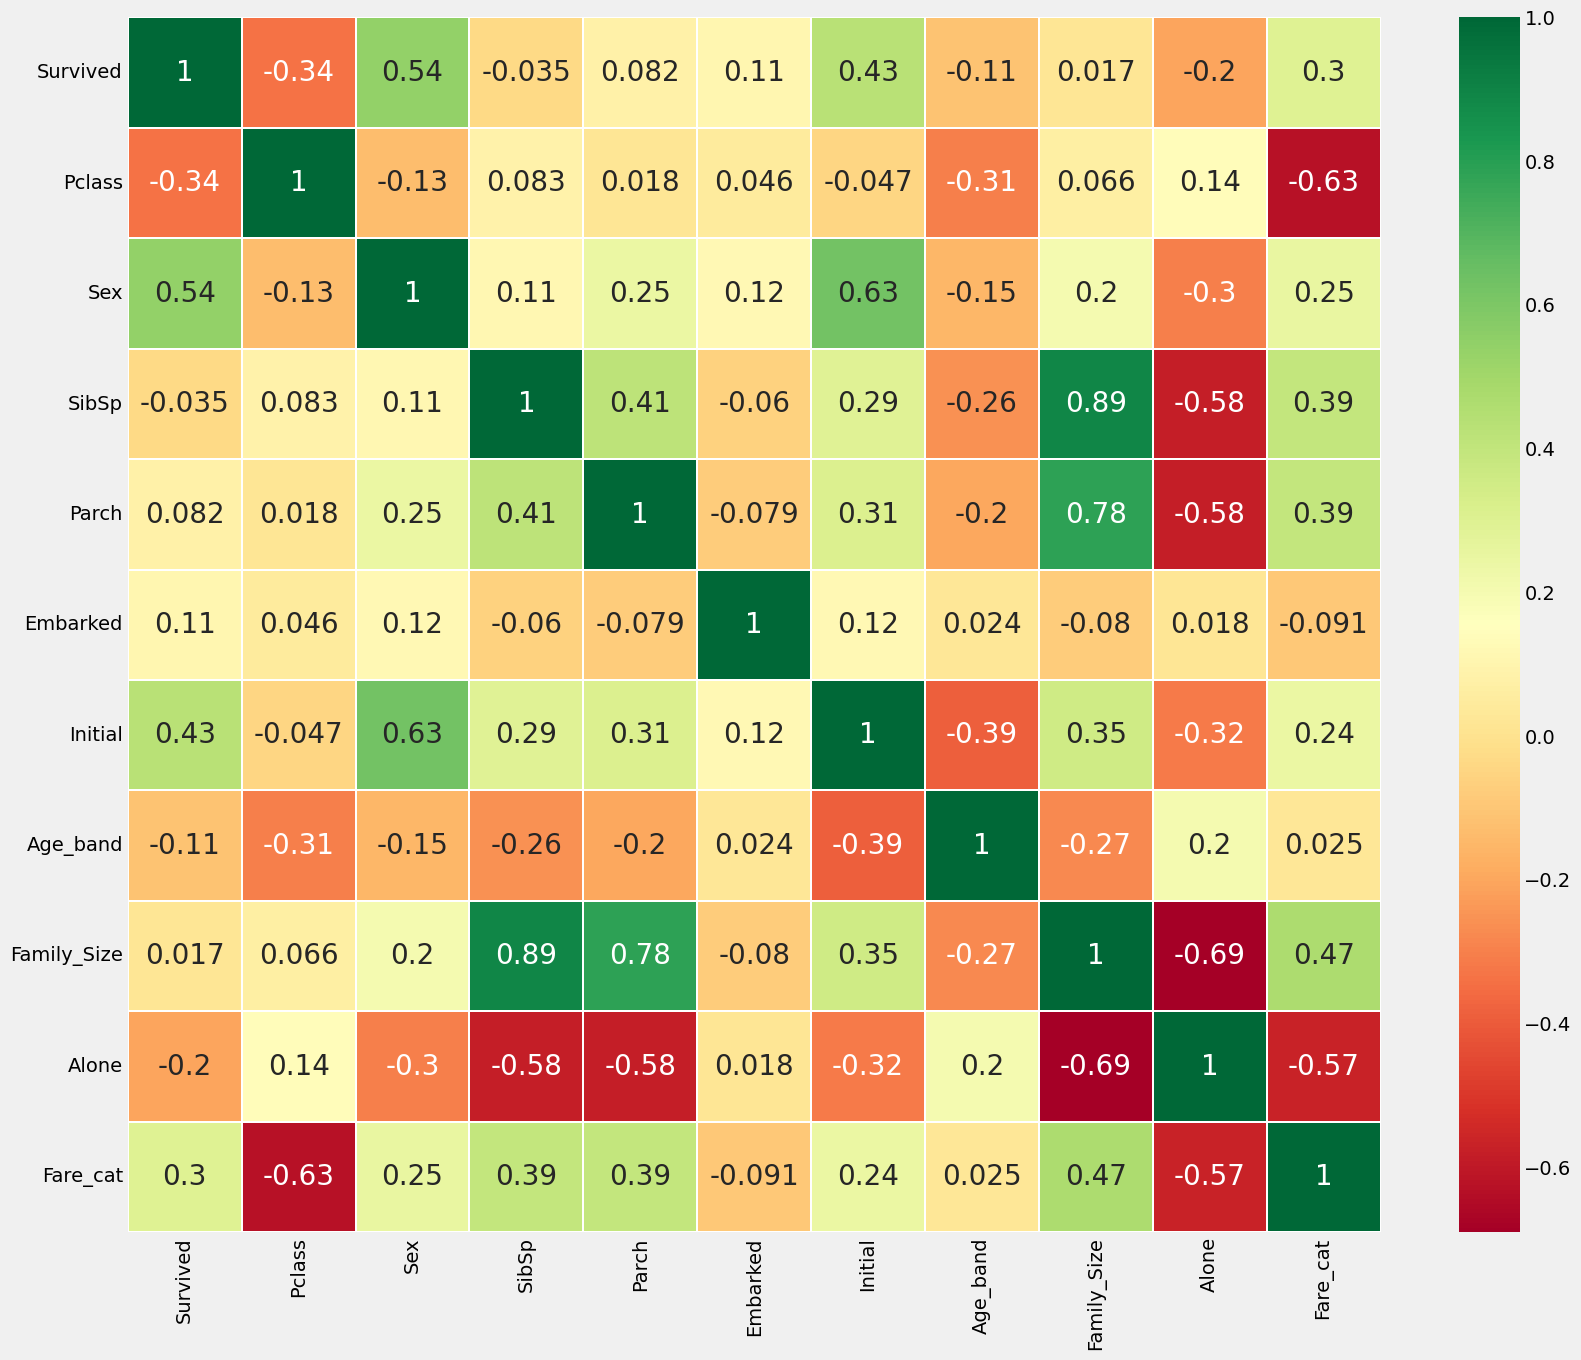

In [26]:
data.drop(['Name', 'Age', 'Ticket', 'Fare', 'Cabin', 'Fare_Range', 'PassengerId'], axis = 1, inplace = True)
sns.heatmap(data.corr(), annot = True, cmap = 'RdYlGn', linewidths = 0.2, annot_kws = {'size':20})
fig = plt.gcf()
fig.set_size_inches(18, 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

위의 상관관계 플롯을 보면 몇 가지 양의 상관관계를 확인할 수 있습니다. 그 중 일부는 SibSp와 Family_Size, Parch와 Family_Size입니다. 그리고 Alone과 Family_Size와 같은 일부 음의 상관관계도 확인됩니다.

# 2. 출처
1. <https://kaggle-kr.tistory.com/32>
2. <https://www.kaggle.com/code/ash316/eda-to-prediction-dietanic/notebook#Cross-Validation>